# Heart Disease UCI

This is a look at the Kaggle project https://www.kaggle.com/ronitf/heart-disease-uci. 

It is the second project I did, where I again work through an existing notebook - https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model - indepth.

It is not intended as a carbon copy, but this notebook closely follows what was done there, using the structure as a guide.

I begin by loading the relevant libraries...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.metrics import f1_score as f1 #for model evaluation
from sklearn.metrics import recall_score as recall #for model evaluation
from sklearn.metrics import precision_score as precision #for model evaluation
from sklearn.model_selection import train_test_split, cross_val_score #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility
import scikitplot as skplt

pd.options.mode.chained_assignment = None  #hide any pandas warnings

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Ple

### Loading and looking at the data

In [2]:
dt = pd.read_csv("../../data/heart.csv")

dt.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

Details of the columns are given on the Kaggle web page above:
    
- **age**: The person's age in years
- **sex**: The person's sex (1 = male, 0 = female)
- **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
- **chol:** The person's cholesterol measurement in mg/dl
- **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false) 
- **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach:** The person's maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more [here](https://litfl.com/st-segment-ecg-library/))
- **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca:** The number of major vessels (0-3)
- **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target:** Heart disease (0 = no, 1 = yes)

In order to clean up the data, we can change the column names to be clearer and to match the example used

In [3]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [4]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

Interestingly, this appears to be almost the opposite from approach to what was done for the last exercise, where all the labels were turned into one-hot variables.

In [5]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

OK, so now in the example we create the one-hot representation. Although, I'm currently not sure why we couldn't work with the original binary sex representation. Maybe this will become clearer when we try to model the data.

In [6]:
dt = pd.get_dummies(dt, drop_first=True) # Maybe we couldn't work with the original binary sex because we "drop_first" and so we'd drop males?

In [7]:
dt.head()

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
0   63                     145          233                      150   
1   37                     130          250                      187   
2   41                     130          204                      172   
3   56                     120          236                      178   
4   57                     120          354                      163   

   st_depression  num_major_vessels  target  sex_male  \
0            2.3                  0       1         1   
1            3.5                  0       1         1   
2            1.4                  0       1         0   
3            0.8                  0       1         1   
4            0.6                  0       1         0   

   chest_pain_type_atypical angina  chest_pain_type_non-anginal pain  \
0                                0                                 1   
1                                1                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   chest_pain_type_typical angina  fasting_blood_sugar_lower than 120mg/ml  \
0                               0                                        0   
1                               0                                        1   
2                               1                                        1   
3                               1                                        1   
4                               0                                        1   

   rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
0                                      0                1   
1                                      0                0   
2                                      0                1   
3                                      0                0   
4                                      0                0   

   exercise_induced_angina_yes  st_slope_flat  st_slope_upsloping  \
0                            0              0                   0   
1                            0              0                   0   
2                            0              1                   0   
3                            0              1                   0   
4                            1              1                   0   

   thalassemia_fixed defect  thalassemia_normal  thalassemia_reversable defect  
0                         0                   1                              0  
1                         1                   0                              0  
2                         1                   0                              0  
3                         1                   0                              0  
4                         1                   0                              0

### The model

First, the example splits the data into train and test, keeping a test size of 0.2.

In [8]:
num_patients = len(dt)
print(num_patients)

303


Since there are only 303 patients, this is probably reasonable

In [9]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10)

Next, we fit construct a random forest classifier and fit

In [10]:
model = RandomForestClassifier(max_depth=5) # Max depth is something that can be optimized
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [11]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [12]:
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True) # This is currently not outputting anything

#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
#
#from IPython.display import Image
#Image(filename = 'tree.png')

Lets use the model on the test data

In [13]:
y_pred_bin = model.predict(X_test)

In [14]:
conf_mat = confusion_matrix(y_test, y_pred_bin)
conf_mat

array([[29,  6],
       [ 4, 22]])

I have copied this directly from the example, as it is good revision...

Diagnostic tests are often sold, marketed, cited and used with **sensitivity** and **specificity** as the headline metrics. Sensitivity and specificity are defined as,

\begin{align}
Sensitivity = \frac{True\:Positives}{True\:Positives + False\:Negatives}
\end{align}

\begin{align}
Specificity = \frac{True\:Negatives}{True\:Negatives + False\:Positives}
\end{align}

These are also called True Positive Rate (or Recall) and True Negative Rate (or Selectivity, but I haven't come across that term before!) It would be good to get an idea of why this is preferred to the F1 score for this example. As a bit of an exercise, I am also going to calculate the F1. And carry out these for the training set as well using the approach adopted in the bank curn example.

In [15]:
# First let's do k-fold cross validation on the training set

f1_train = cross_val_score(model ,X_train, y_train, cv=5, scoring='f1')
print('F1 train score = ', np.mean(f1_train))

# First let's do k-fold cross validation on the training set for recall

recall_train = cross_val_score(model ,X_train, y_train, cv=5, scoring='recall')
print('Recall train score = ', np.mean(recall_train))
precision_train = cross_val_score(model ,X_train, y_train, cv=5, scoring='precision')
print('Precsion train score = ', np.mean(precision_train))

F1 train score =  0.8478117413140092
Recall train score =  0.9063492063492063
Precsion train score =  0.8356789456534788


In [16]:
# Now lets look at the F1 for the test set

print('F1 test score - {}'.format(f1(y_pred_bin ,y_test)))
print('Recall test score - {}'.format(recall(y_pred_bin ,y_test)))
print('Precision test score - {}'.format(precision(y_pred_bin ,y_test)))

F1 test score - 0.8148148148148148
Recall test score - 0.7857142857142857
Precision test score - 0.8461538461538461


There appears to be a drop in recall for the test dataset. Let's continue with what was in the original example for now. This may present an opportunity to investigate this further.

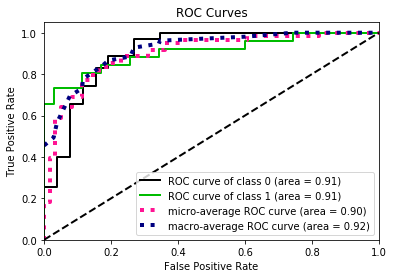

In [17]:
y_pred_quant = model.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, y_pred_quant)

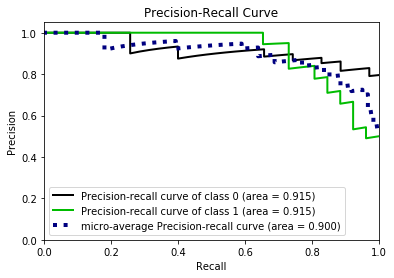

In [18]:
skplt.metrics.plot_precision_recall(y_test, y_pred_quant)

These values for AUC seem to indicate the model is doing well

As a rule of thumb, **AUC** is a convenient way to capture the performance of a model in a single number, although it's not without certain issues:

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail

### Explanation

Some of the concepts in this section are new to me, so some of this will be a carbon copy.

As a starting point, we use permutations of the variables to assess their effect on the accuracy. A description of this type of test can be found here https://scikit-learn.org/stable/modules/permutation_importance.html

In [19]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Next we look at some partial dependence plots. More information on these can be found here https://www.kaggle.com/dansbecker/partial-plots.

Main thing for me is that the plot shows the "change in the prediction from what it would be predicted at the baseline or leftmost value" for a change in the value of the feature of interest. 

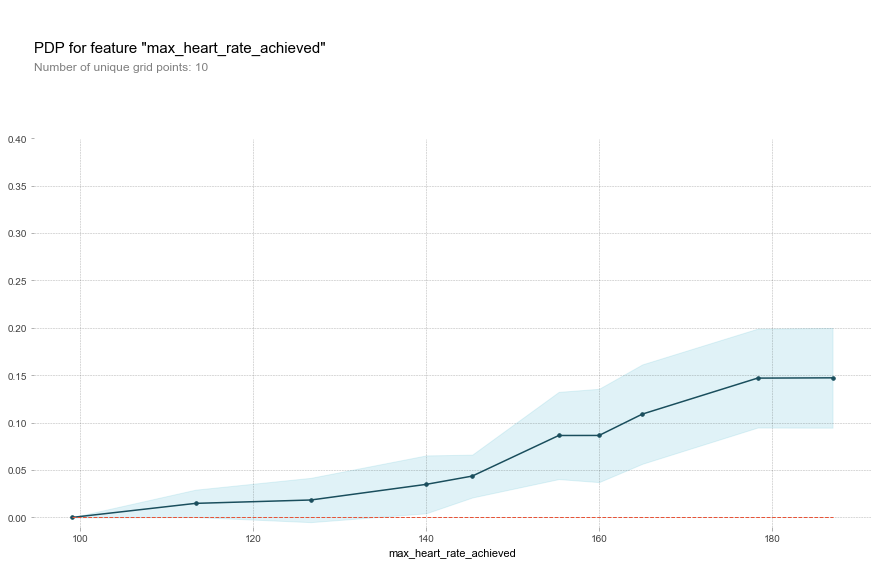

In [20]:
base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'max_heart_rate_achieved'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

So from this plot we see that the probability of having heart disease increases - quite linearly - with the max_heart_rate_achieved parameter, starting at zero chance when max heart rate is < 100 bpm.

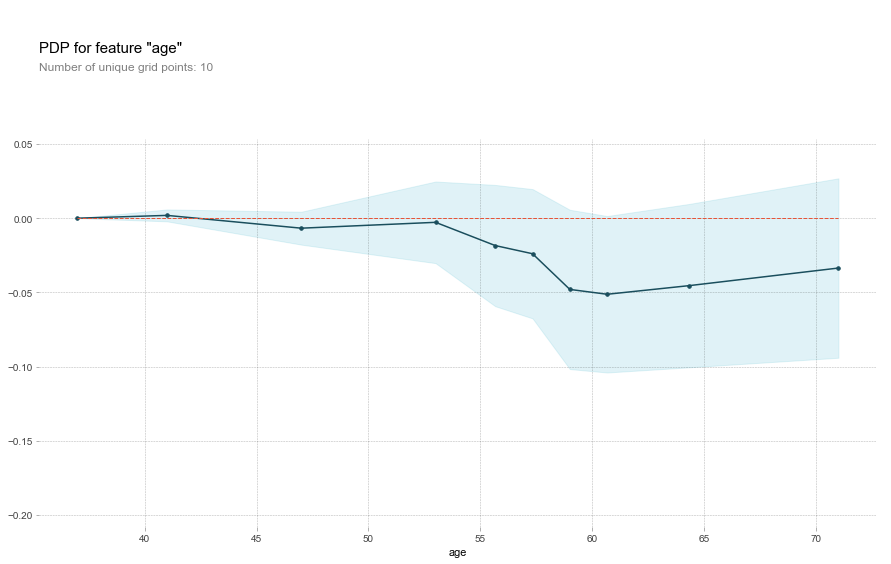

In [21]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

This plot seems to indicate that the higher the age, the lower the chance of heart disease! But we also see that the zero line is within the confidence region, so this cannot be concluded from the data.

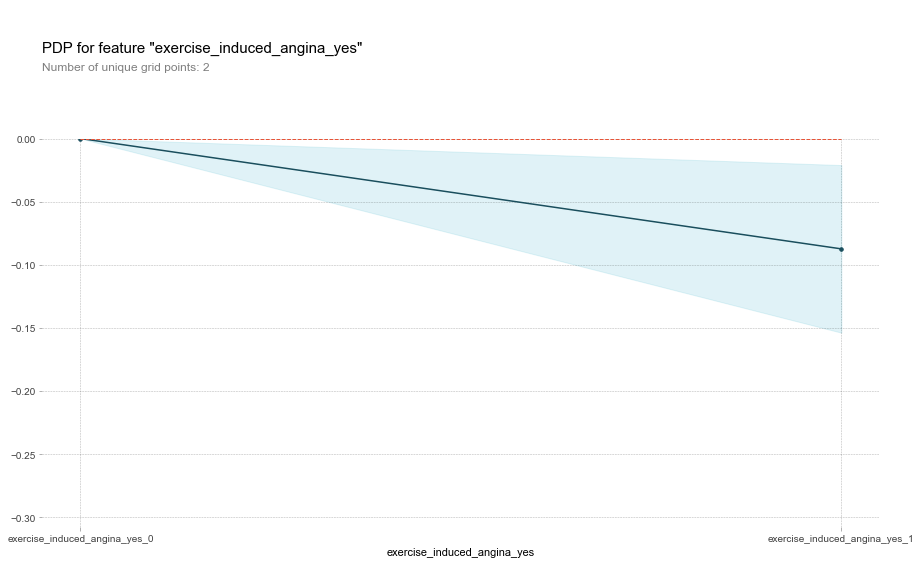

In [34]:
feat_name = 'exercise_induced_angina_yes'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

Not sure about this!

Next, lets look at st_depression

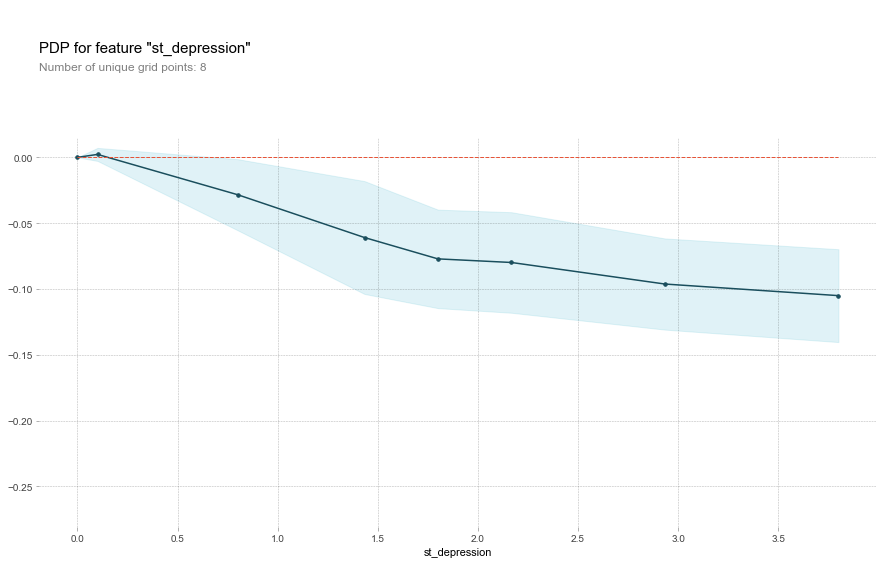

In [22]:
feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

As st_depression increase, chances of heart disease decrease.

Looking at some 2D plots with respect to the slope of the st:

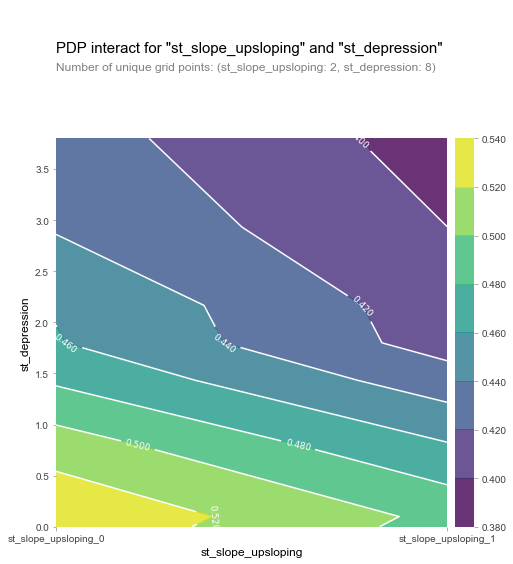

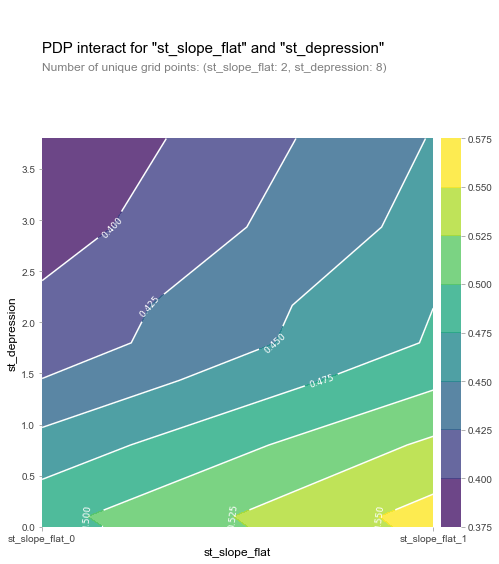

In [23]:
inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_upsloping', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_upsloping', 'st_depression'], plot_type='contour')
plt.show()

inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_flat', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_flat', 'st_depression'], plot_type='contour')
plt.show()

This shows the same thing. There is a better description of this in the example notebook used to create this notebook. I am using this to get familiar with these tools!

Now we use SHAP (https://www.kaggle.com/dansbecker/shap-values) to look at the imapct of all the features:

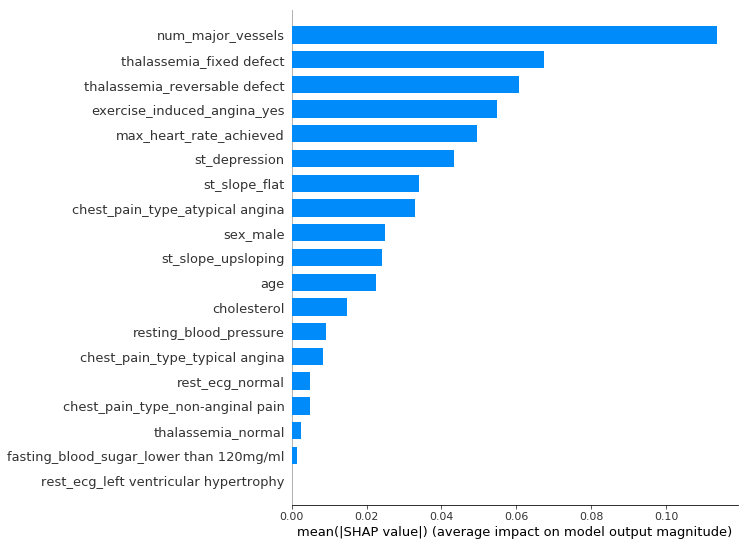

In [51]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

Here, we see that the biggest effect on the impact on the model magnitude. I still need to understand why there quite a big difference between this and the permutation importance above.

Here is a summary plot

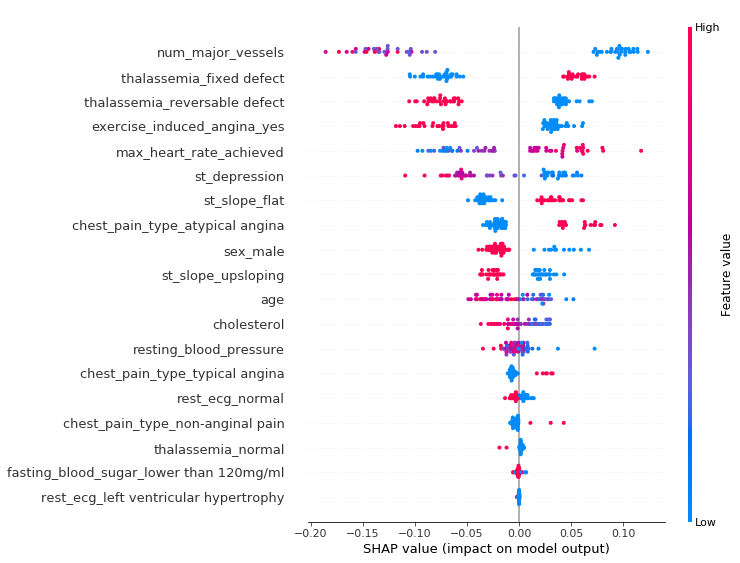

In [52]:
shap.summary_plot(shap_values[1], X_test)

This is a pretty good plot. It clearly shows a division for a number of the feature!

Next we look at the results for an individual patient.

In [53]:
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [54]:
data_for_prediction = X_test.iloc[0,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

This patient is pretty much in the clear! With a prediction of 6% chance. They have a good number of major blood vessels and thalassemia_reversable_defect=1.

We can also look at SHAP dependence plots: https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

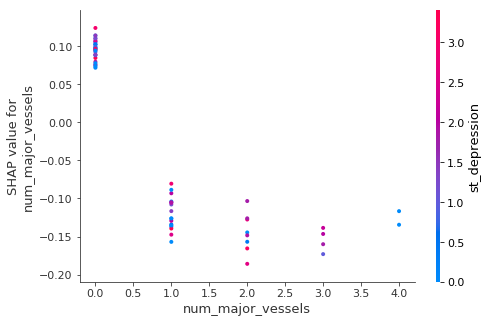

In [55]:
shap.dependence_plot('num_major_vessels', shap_values[1], X_test, interaction_index="st_depression")

In [56]:
shap_values2 = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values2[1], X_test.iloc[:50])